---
# <span style="color:blue">**Tests for different encoding of features and for disentangling vertical from horizontal port scans**</span>
---

In this notebook, the tests mentioned below are performed according to the observations from the EDA. Their purpose is to understand:
- what is the best encoding of the categorical features mainly because:
    - an IP address can be encoded in different ways (here only the two used in the EDA are explored) and
    - the history has more than 100 unique values which translates to nunique added features in case of dummy encoding; one for e.g. could already potentially reduce the number of features with a better encoding in the preprocessing step without the need of a dimensionality reduction   or a feature selection algorithm. On the other hand, the enumerated encoding of this feature has shown a correlation of 0.7 with the target. 
- if the additional features explored (transformations and binary features) improve the classification task 
- if disentangling the vertical from the horizontal scans does not confuse a classifier

For these tests, the classifier that is used is the *RandomForestClassifier*, mainly because the weights associated with each class can be adjusted, in this case inversely proportional to the class frequencies, in order to tackle the imbalance of the classes. Since the purpose of these tests here is not to tune the classifier itself but rather to get a rough idea for the questions addressed above, the parameters that had been set are the following: 
- the number of trees is fixed to 10 
- the *max_features* has been set to *None* in order for all the features to be taken into account
- the *bootstrap* flag has been turned off in order for the whole dataset to be taken into account 
- the *random_state* is fixed to 0 (even if the *max_features* and *bootstrap* has been set)

The dataset is initially split into 70-30 for training and testing. Consecutively, the training set is split into 80-20, 70-30, 60-40, 50-50 over 10 different random states for training and validation. To distinguish the different type of traffic flows on these tests (both benign and malicious), here only the *f1-weighted score* and the *confusion matrices* are averaged over the different random states per splitting and reported for each test. According to the results obtained from each test, a decision will be mabe for the final preprocessing of the data later. For these tests, the test sample is not used. However, it was generated using a fixed random state (of zero) in order to be always the same. 

The 1st test starts by encoding all the categorical features except the IPv4 addresses to dummies, while the IPv4 addresses are converted into 4 octets. For the rest of the tests the differences are marked in bold. For each consecutive test, the best decision is made by comparing the results with the previous ones. 

*NOTE: Since the confusion matrices are normalized along the total number of samples per row (along the actual direction) for a better representation, the number of precision has been set on purpose to 4 digits to catch up small differences in between the tests. Also the precision of the f1-score is on purpose left to 5 digits for the same reason.*


**Test1**: 
- All categorical (except IP addresses) to dummies
- IP addresses to octets


**Test2**: 
- **Different encoding of categorical features (except the IP addresses)**
- IP addresses to octets
    

**Test3**: 
- Best representation of categorical encoding (except IP addresses)
- **Encoding of IP addresses to integers**


**Test4**: 
- Best representation of categorical encoding
- Best encoding of IP addresses
- **Add the binary features from the *ip_address* lib which have shown a small anticorrelation with the target**


**Test5**: 
- Best representation of categorical encoding
- Best encoding of IP addresses
- Best decision for the binaries  
- **Add transformations of numerical features**
    
    
**Test6**: 
- Best representation of categorical encoding
- Best encoding of IP addresses
- Best decision for the binaries  
- Best decision for the transformation of the numerical features
- **Disentangle Horizontal from vertical scans** 

---

In [1]:
# basic libs
import os
import pandas as pd
import numpy as np

# utils lib
import utils.preprocess as pre
import utils.testing as testing

# plot libs
import seaborn as sns
from matplotlib import pyplot as plt, dates
%matplotlib inline

---
### **Load data and split into sets**
---

In [2]:
# Read data
data_df = pd.read_csv(os.path.join('data', 'ioT_data_reduced.csv'))
print('Dataframe shape:', data_df.shape)

Dataframe shape: (202402, 23)


In [3]:
from sklearn.model_selection import train_test_split

# Split features and target
X = data_df.drop(['label', 'detailed_label'], axis=1)
y = data_df['detailed_label'].replace({'-': 0,
                                       'PartOfAHorizontalPortScan':1, 
                                       'C&C' : 2,
                                       'DDoS': 3,
                                       'Attack':4
                                      }).values

# Keep 30% of the data for test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
print('Train size:', X_tr.shape[0])
print('Test size:', X_te.shape[0])

Train size: 141681
Test size: 60721


---
### **Define the pipeline**
---

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Categorical Features for transformation
cols_to_dummies = ['protocol', 'conn_state', 'history']

# Define the pipeline
pipe = Pipeline([('recover_nulls', pre.RecoverNansPreprocessor()),
                 ('cleaning_preprocessor', pre.CleaningPreprocessor()), 
                 ('categorical_preprocessor', pre.CategoricalPreprocessor(cols_to_dummies = cols_to_dummies, 
                                                                          cols_to_numeric = [])),
                 ('numerical_preprocessor', pre.NumericalPreprocessor(cols_to_logs = [], 
                                                                      cols_to_pt = [], 
                                                                      cols_to_quantile = [], 
                                                                      replace = False)),
                 ('add_binaries', pre.AddBinariesPreprocessor(has_ip_address_features=False)),
                 ('ip_encoding', pre.IPEncodingPreprocessor(ip_to_octets = True)),
                 ('clf', RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', 
                                                max_features=None, bootstrap=False, random_state=0))
])

---
### **Test 1**
- All categorical (except IP addresses) to dummies
- IP addresses to octets
---

In [5]:
# Fit and get results
gs_results_test_1 = testing.fit_pipe(X_tr, y_tr, pipe)

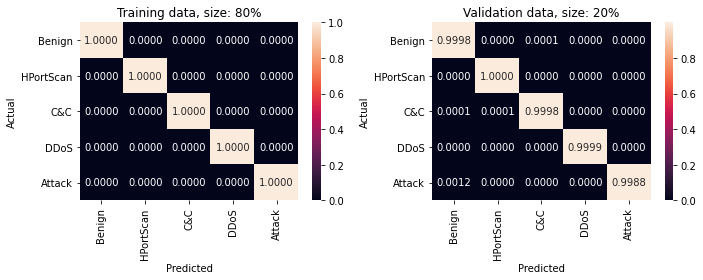

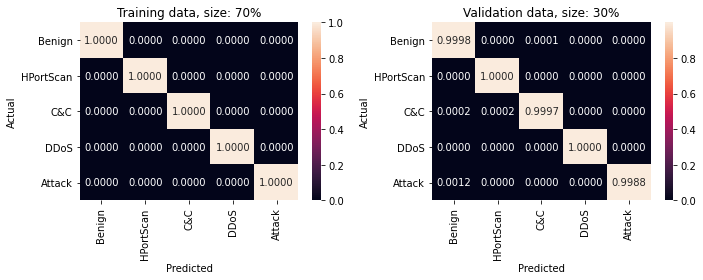

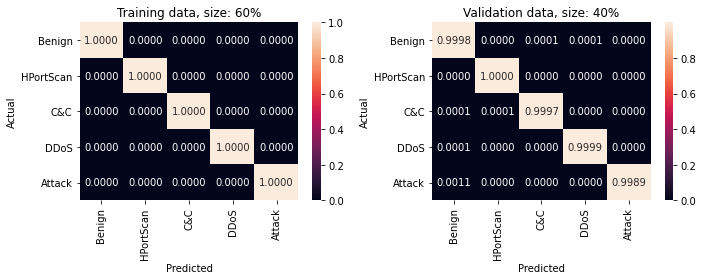

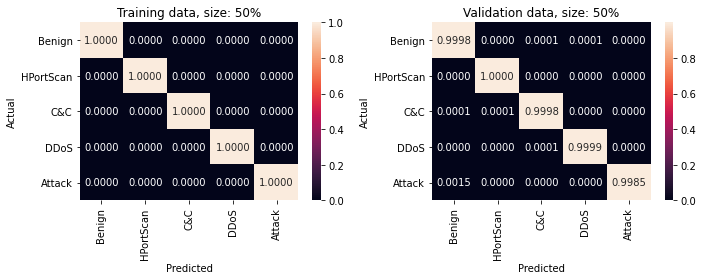

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.999905,0.000058
1,30,1.0,0.0,0.999913,0.000039
2,40,1.0,0.0,0.999906,0.000042
3,50,1.0,0.0,0.999901,0.000037


In [6]:
# Show results
gs_results_test_1_avg = testing.average_results(gs_results_test_1)

> By encoding all the categorical feautures to dummies and the IP addresses with octets, the Random Forest Classifier gives already a very good classification across all different splittings. The *f1-weighted* score for both training set has reached each maximum, while for the vadidation set is very close to the maximum for all different splittings. From the confusion matrices on the validation set, we see that there is a very small percentage of misclassification for the following classes:
> - Benign entries misclassified as C&C and DDoS
> - C&C entries misclassified as benign and horizontal port scans
> - DDoS entries misclassified as C&C
> - Attack entries misclassified as benign

> while for the horizontal port scans entries there is no misclassification. 

---
### **Test 2**
- **Different encoding of categorical features except the IP addresses**
- IP addresses to octets
---

> - In the EDA, the pearson correlation matrix has been produced by encoding the categorical features *history*, *protocol* and *conn_state*  as an enumerated type using the *factorize* method of pandas. By doing so, we have seen a correlation of 0.7, 0.3 and -0.2 respectively with the target variable. 
> - In this test the same encoding will be set, either for all three features or only for the *history* which has shown the highest correlation. 

---
**2.1 All categorical features to numeric encoding**

---

In [7]:
# Change parameters for the categorical features
pipe.set_params(categorical_preprocessor__cols_to_dummies=[])
pipe.set_params(categorical_preprocessor__cols_to_numeric=cols_to_dummies)

# Fit and get results
gs_results_test_2_1 = testing.fit_pipe(X_tr, y_tr, pipe)

/home/osidirop/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/osidirop/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/osidirop/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/osidirop/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

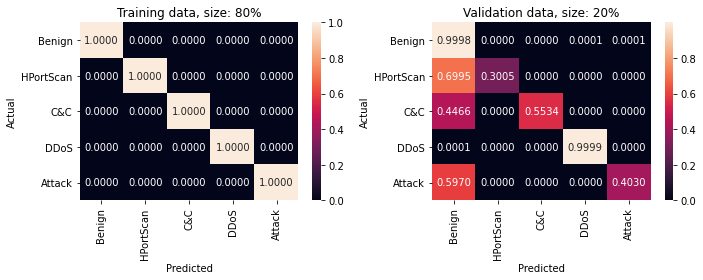

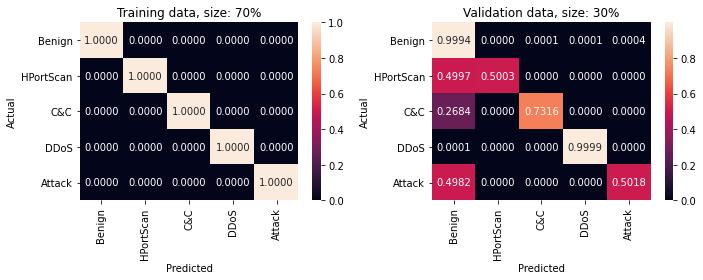

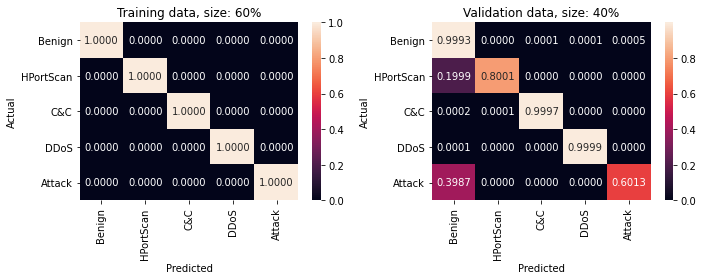

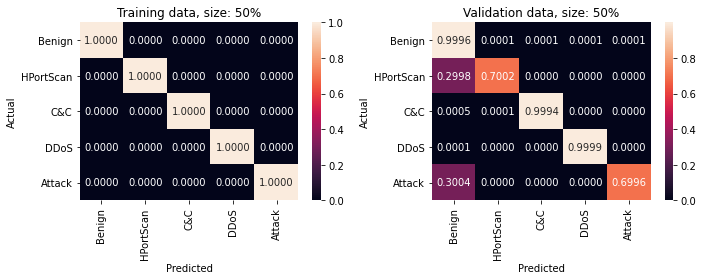

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.384497,0.369629
1,30,1.0,0.0,0.563852,0.442850
2,40,1.0,0.0,0.824117,0.337783
3,50,1.0,0.0,0.749431,0.393809


In [8]:
# Show results
gs_results_test_2_1_avg = testing.average_results(gs_results_test_2_1)

> The numerical encoding of all three categorical features is not the best representation as the f1-score is ill defined for the classes where we see a large misclassification across the different splittings.

---
**2.2 *Protocol* and *conn_state* to dummies, *history* with numeric representation**

---

In [9]:
cols_to_dummies = ['protocol', 'conn_state']
cols_to_numeric = ['history']

# Change parameters for the categorical features
pipe.set_params(categorical_preprocessor__cols_to_dummies=cols_to_dummies)
pipe.set_params(categorical_preprocessor__cols_to_numeric=cols_to_numeric)

# Fit and get results
gs_results_test_2_2 = testing.fit_pipe(X_tr, y_tr, pipe)

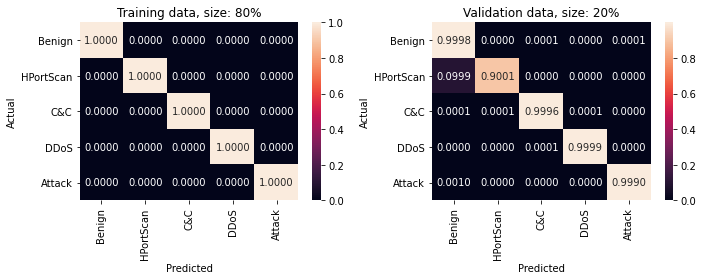

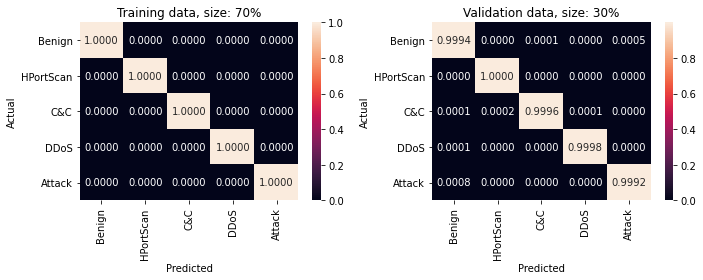

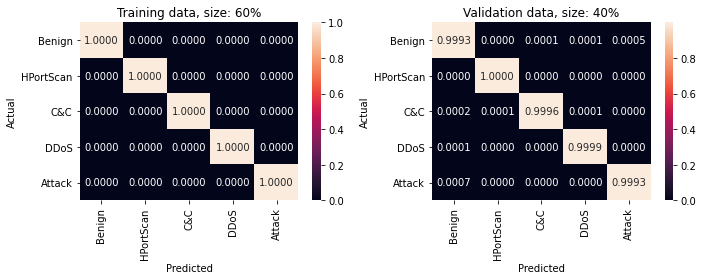

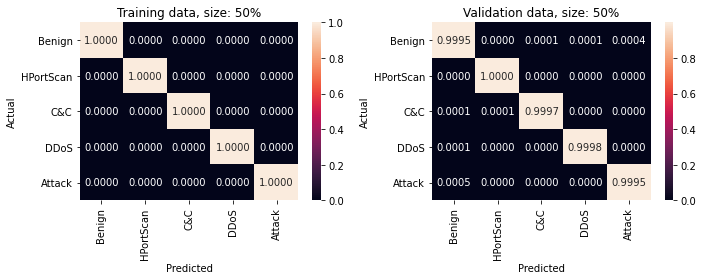

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.919860,0.253128
1,30,1.0,0.0,0.999866,0.000141
2,40,1.0,0.0,0.999871,0.000117
3,50,1.0,0.0,0.999887,0.000093


In [10]:
# Show results
gs_results_test_2_2_avg = testing.average_results(gs_results_test_2_2)

> - By encoding only the feature *history* to numeric the difference wrt the first test is subtle except for the training-validation splitting 80-20 where there is an increase of ~1% of horizontal port scan entries missclassified as benign. 
> - From this test we can conclude that the best encoding of those features is the dummy one and will be kept for the rest of the tests.  

---
### **Test 3**
- All categorical to dummies
- **Enconging of the IPv4 addresses as integers**
---

In [11]:
# Change parameters for the categorical features to be coverted to dummies
cols_to_dummies = ['protocol', 'conn_state', 'history']
pipe.set_params(categorical_preprocessor__cols_to_dummies=cols_to_dummies)
pipe.set_params(categorical_preprocessor__cols_to_numeric=[])

# IP addresses to integers
pipe.set_params(ip_encoding__ip_to_octets=False)
pipe.set_params(ip_encoding__ip_to_integers=True)


# Fit and get results
gs_results_test_3 = testing.fit_pipe(X_tr, y_tr, pipe)

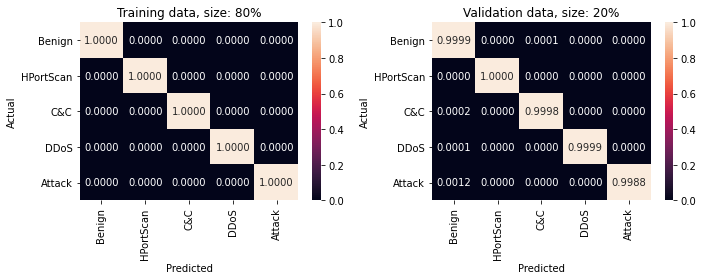

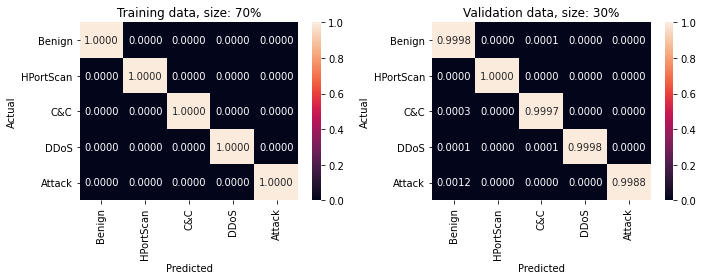

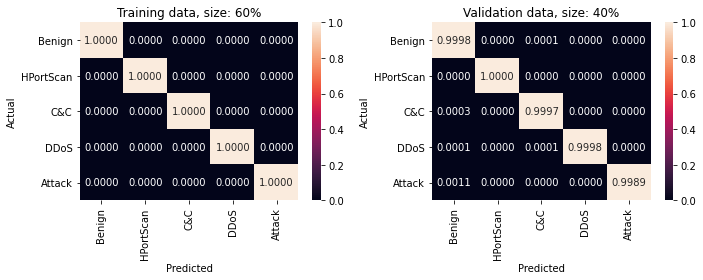

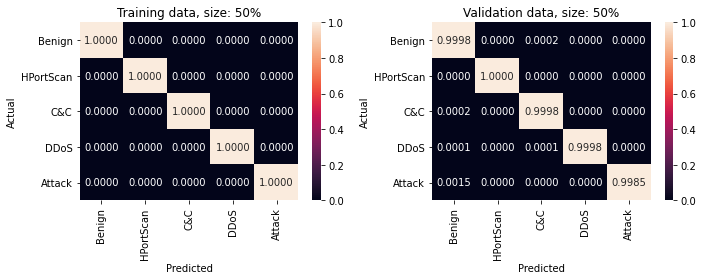

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.999922,0.000049
1,30,1.0,0.0,0.999915,0.000040
2,40,1.0,0.0,0.999915,0.000023
3,50,1.0,0.0,0.999901,0.000029


In [12]:
# Show results
gs_results_test_3_avg = testing.average_results(gs_results_test_3)

> By encoding the IP addresses to integers, the difference wrt the 1st test is subtle and since this encoding slows down the preprocessing step as it is performed entry-by-entry, the octet representation of the IPv4 addresses will be kept as the best encoding for the rest of the tests. 

---
### **Test 4**
- All categorical to dummies (except IP addresses)
- IP addresses to octets
- **Add binary features from the *ip address* library**
---

> In the EDA we have seen that the only binary features from the *ipaddress* library which had a small anticorrelation with the target value were the:
>  - *origin_is_private* and *origin_is_global* with an anticorrelation of 0.1 and the
>  - *response_is_private* and *response_is_global* with an anticorrelation of 0.2

> In this test, those 4 features will be added. 
---

In [13]:
# Change the encoding of the ip addresses to octets
pipe.set_params(ip_encoding__ip_to_integers=False)
pipe.set_params(ip_encoding__ip_to_octets=True)

# Add the binary features
pipe.set_params(add_binaries__has_ip_address_features=True)

# Fit and get results
gs_results_test_4 = testing.fit_pipe(X_tr, y_tr, pipe)

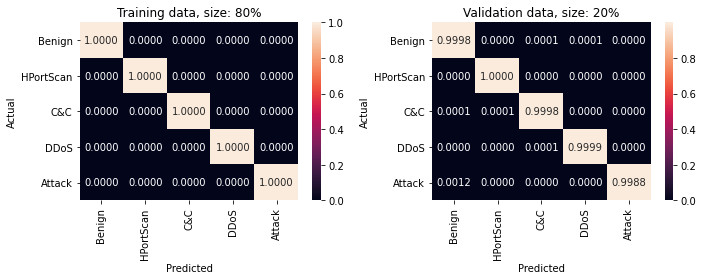

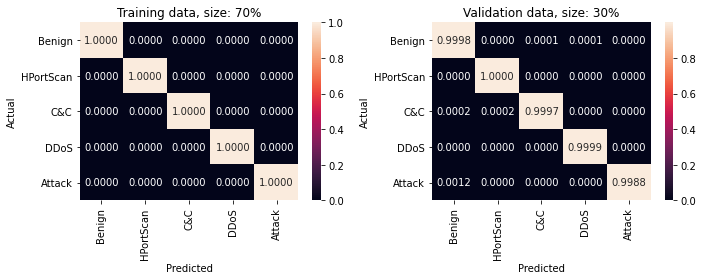

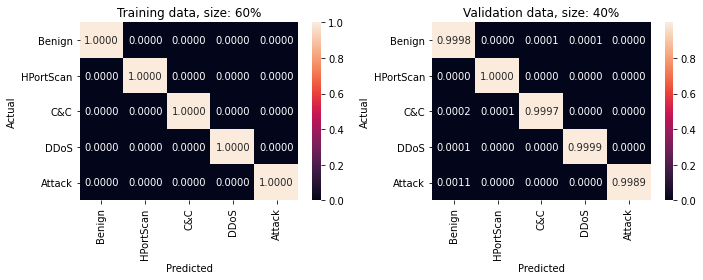

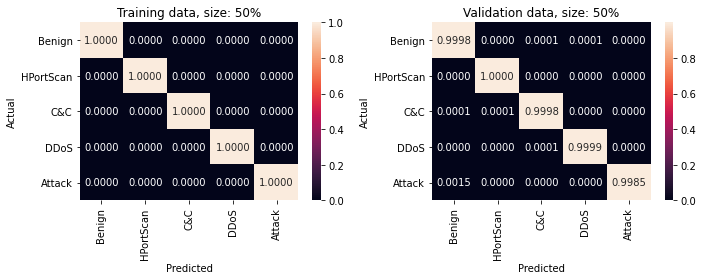

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.999915,0.000056
1,30,1.0,0.0,0.999911,0.000043
2,40,1.0,0.0,0.999908,0.000035
3,50,1.0,0.0,0.999903,0.000038


In [14]:
# Show results
gs_results_test_4_avg = testing.average_results(gs_results_test_4)

> As expected, there is not a real difference wrt the first test as the anti-correlation of those features with the target is very small. In addition, because the addition of those features is performed entry-by-entry and slows down the preprocessing step will not be considered for the following tests. 

---
### **Test 5**
- All categorical to dummies (except IP addresses)
- IP addresses to octets
- No added binary features
- **Transformation of Numerical features**
---

> As we have seen from the EDA, none of the distributions of transformed numerical features was perfect except the power transformed *duration* which was normally distributed. Nevertheless, here all the three transformations (log, power and quantile) will be added as additional features and tested. 

---

**5.1 Add log transformations**

---

In [15]:
# Remove the binaries
pipe.set_params(add_binaries__has_ip_address_features=False)

# Define numeric columns for transformations
cols_num = ['origin_port',
            'response_port',
            'duration',
            'orig_bytes',
            'resp_bytes',
            'orig_pkts',
            'orig_ip_bytes',
            'resp_pkts',
            'resp_ip_bytes']

# Add log transformated features
pipe.set_params(numerical_preprocessor__cols_to_logs=cols_num)

# Fit and get results
gs_results_test_5_1 = testing.fit_pipe(X_tr, y_tr, pipe)

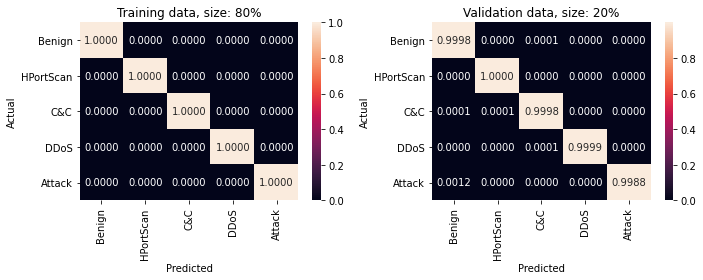

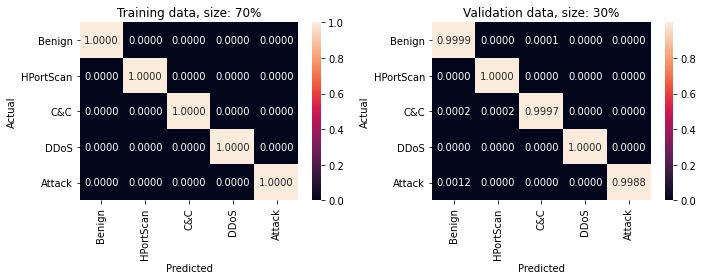

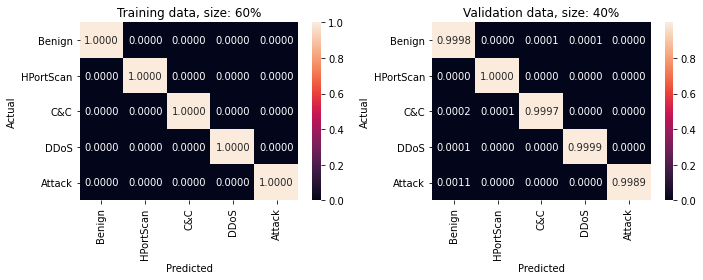

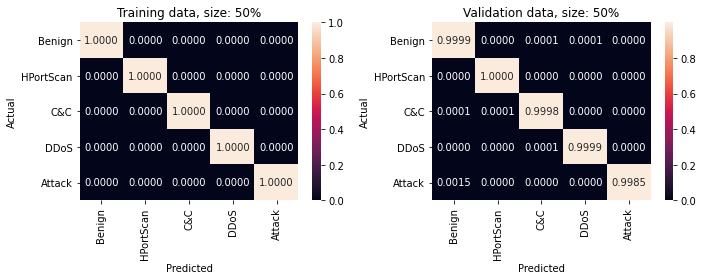

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.999915,0.000063
1,30,1.0,0.0,0.999922,0.000042
2,40,1.0,0.0,0.999908,0.000032
3,50,1.0,0.0,0.999907,0.000040


In [16]:
# Show results
gs_results_test_5_1_avg = testing.average_results(gs_results_test_5_1)

> By adding the log transformations there is no essential change in the results. 

---
**5.2 Add power transformations**

---

In [17]:
# Change the parameters in the pipeline
pipe.set_params(numerical_preprocessor__cols_to_pt=cols_num)
pipe.set_params(numerical_preprocessor__cols_to_logs=[])

# Fit and get results
gs_results_test_5_2 = testing.fit_pipe(X_tr, y_tr, pipe)

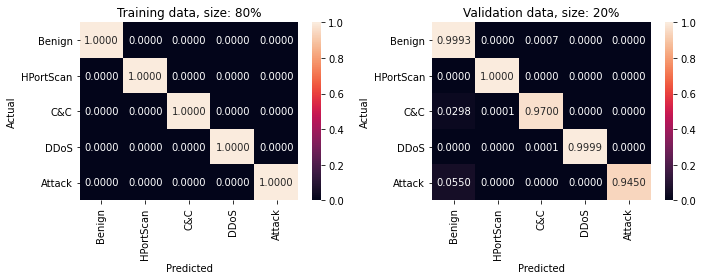

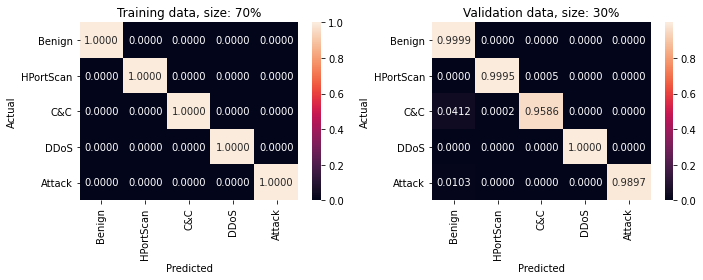

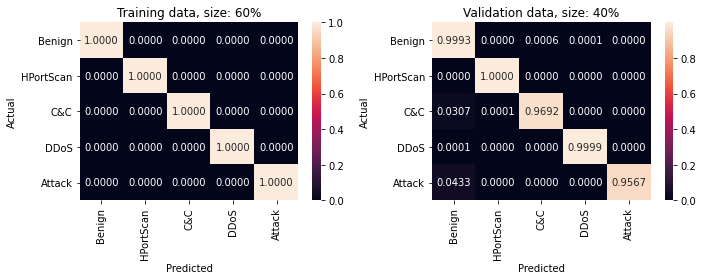

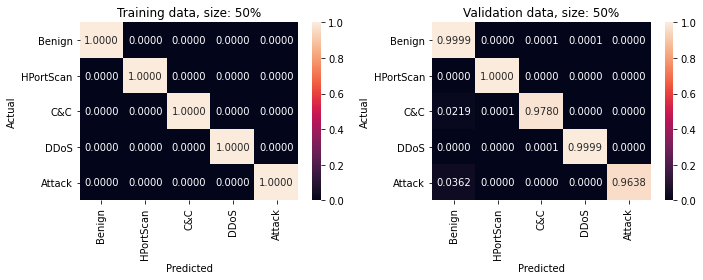

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.996044,0.003489
1,30,1.0,0.0,0.996261,0.004295
2,40,1.0,0.0,0.996328,0.002963
3,50,1.0,0.0,0.997256,0.003103


In [18]:
# Show results
gs_results_test_5_2_avg = testing.average_results(gs_results_test_5_2)

> By adding the power transformed numerical features there is a more evident difference on the validation data. In particular the misclassification of the C&C and Attack entries was increased by ~3-4% across the different splittings. This was somehow expected as according to the EDA the distrubutions of the power transformed features of the:
> - *orig_bytes*
> - *resp_bytes*
> - *resp_ip_bytes* and 
> - *resp_pkts*

> were not at all good. 

---
**5.3 Add quantile transformations**

---

In [19]:
# Change the parameters in the pipeline
pipe.set_params(numerical_preprocessor__cols_to_pt=[])
pipe.set_params(numerical_preprocessor__cols_to_logs=[])
pipe.set_params(numerical_preprocessor__cols_to_quantile=cols_num)

# Fit and get results
gs_results_test_5_3 = testing.fit_pipe(X_tr, y_tr, pipe)

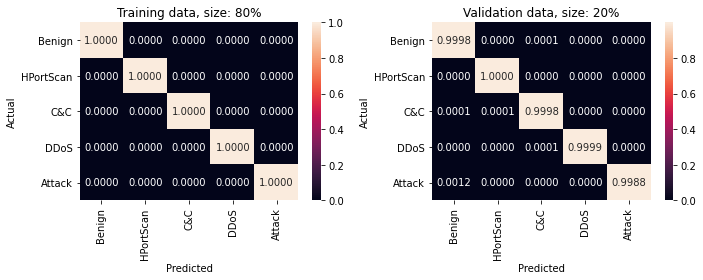

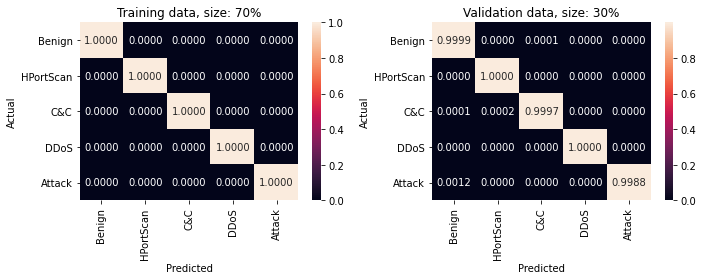

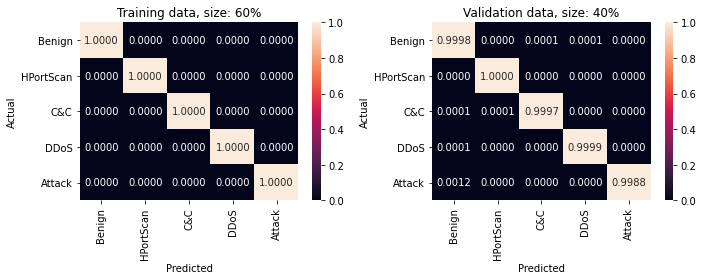

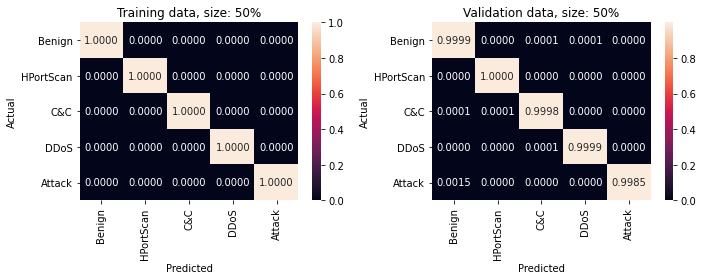

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.999915,0.000053
1,30,1.0,0.0,0.999925,0.000036
2,40,1.0,0.0,0.999919,0.000036
3,50,1.0,0.0,0.999900,0.000055


In [20]:
# Show results
gs_results_test_5_3_avg = testing.average_results(gs_results_test_5_3)

> With the addition of the quantile transformatations, the difference is again subtle.

---
### **Test6**: 
- All categorical to dummies (except IP addresses)
- IP addresses to octets
- W/o the addition of binary features
- W/o the addition of transformed features
- **Disentangle Horizontal from vertical scans** 

---

**Preprocessing step for separating horizontal from vertical scans**

---

In [21]:
# Define preprocessing step to correct the scans
def preprocess_step(input_df, first_correction=False, second_correction=False):
    
    # Get a copy of the dataframe
    df = input_df.copy()

    # First correction
    if first_correction==True:
    
        origin_addresses = ['192.168.2.5', '192.168.1.195']
        response_ports  = [59353, 63798]

        for orig_add, resp_port in zip(origin_addresses, response_ports):

            mask = df.loc[(df['detailed_label']=='PartOfAHorizontalPortScan') &
                          (df['origin_address']==orig_add) &
                          (df['response_port']==resp_port)].index

            df.loc[mask, 'detailed_label'] = 'PartOfAVerticalPortScan'

    # Second (possible) correction
    if second_correction==True:           
    
        df_uniques = df.loc[(df['detailed_label']=='PartOfAHorizontalPortScan') &
                               (df['origin_address']=='192.168.2.5') &
                               (df['response_port']==22)].groupby('origin_port')['response_address'].nunique().to_frame().reset_index()


        # Get a list of ports for response_addresses that appear only once
        ls_ = df_uniques.loc[df_uniques['response_address']==1]['origin_port'].to_list()   

        mask = df[df['origin_port'].isin(ls_)].index
        df.loc[mask, 'detailed_label'] = 'PartOfAVerticalPortScan'
    

    return df

---
**6.1 First correction**

---

In [22]:
# process input data to correct the labels
data_df2 = preprocess_step(data_df, first_correction=True)

In [23]:
# Split data to X, y
X = data_df2.drop(['label', 'detailed_label'], axis=1)
y = data_df2['detailed_label'].replace({'-': 0,
                                       'PartOfAHorizontalPortScan':1, 
                                       'C&C' : 2,
                                       'DDoS': 3,
                                       'Attack':4,
                                       'PartOfAVerticalPortScan':5
                                      }).values

# Keep 30% of the data for test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [24]:
# Categorical Features for transformation
cols_to_dummies = ['protocol', 'conn_state', 'history']

# Redefine the pipeline
pipe = Pipeline([('recover_nulls', pre.RecoverNansPreprocessor()),
                 ('cleaning_preprocessor', pre.CleaningPreprocessor()), 
                 ('categorical_preprocessor', pre.CategoricalPreprocessor(cols_to_dummies = cols_to_dummies)),
                 ('ip_encoding', pre.IPEncodingPreprocessor(ip_to_octets = True)),
                 ('clf', RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', 
                                                max_features=None, bootstrap=False, random_state=0))
])

In [25]:
# Fit and get results
gs_results_test_6_1 = testing.fit_pipe(X_tr, y_tr, pipe)

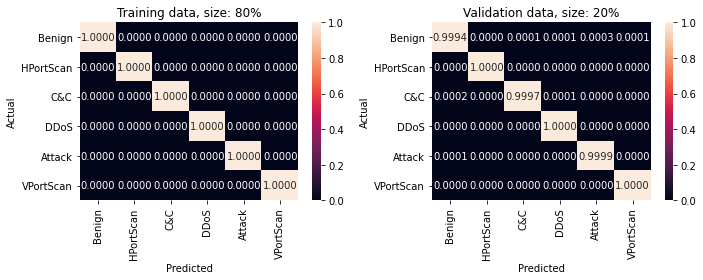

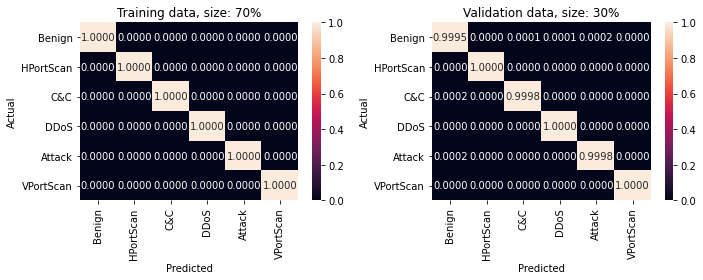

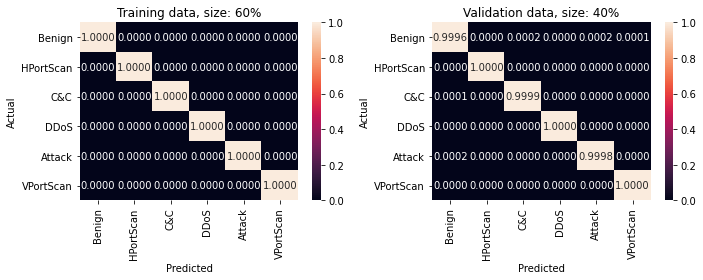

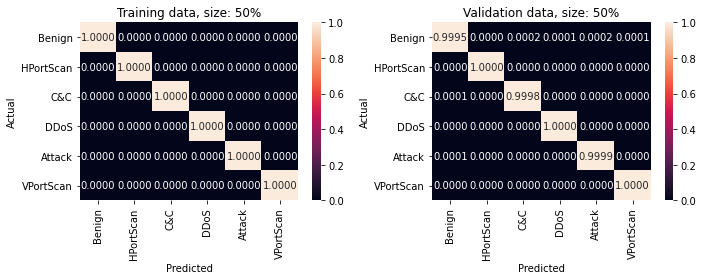

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.999908,0.000038
1,30,1.0,0.0,0.999927,0.000032
2,40,1.0,0.0,0.999938,0.000028
3,50,1.0,0.0,0.999931,0.000025


In [26]:
# Show results
gs_results_test_6_1_avg = testing.average_results(gs_results_test_6_1, vertical_scans=True)

> By correcting the labels for the entries coming from the IP origin addresses 192.168.2.5 and 192.168.1.195 and response ports 59353 and 63798 respectively, we see that the classifier can distinguish very well the horizontal from the vertical scans without confusing them across the different splittings. However, there is a small percentage of Benign entries misclassified as Attack that was not the case before, as well as, vertical port scans. On the other hand, the percentage of Attack entries misclassified as Benign was slightly decreased, as well as the percentage of C&C misclassified as horizontal port scans. For this reason probably we see a subtle increase in the mean of the *f1-weighted* score and a subtle decrease of the standard deviation. 

---
**6.2 Add second correction**

---

In [27]:
# process input data to correct the labels
data_df3 = preprocess_step(data_df, first_correction=False, second_correction=True)

In [28]:
# Split data to X, y
X = data_df3.drop(['label', 'detailed_label'], axis=1)
y = data_df3['detailed_label'].replace({'-': 0,
                                       'PartOfAHorizontalPortScan':1, 
                                       'C&C' : 2,
                                       'DDoS': 3,
                                       'Attack':4,
                                       'PartOfAVerticalPortScan':5
                                      }).values

# Keep 30% of the data for test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [29]:
# Fit and get results
gs_results_test_6_2 = testing.fit_pipe(X_tr, y_tr, pipe)

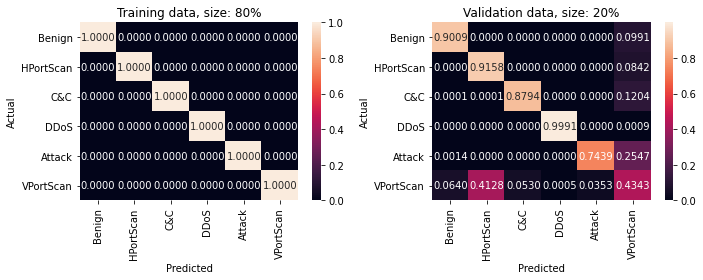

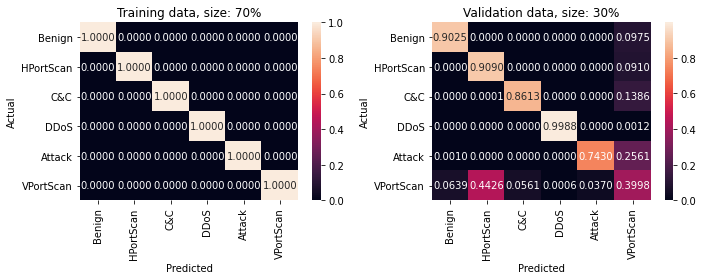

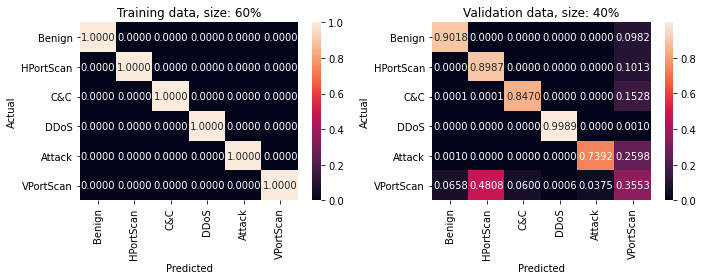

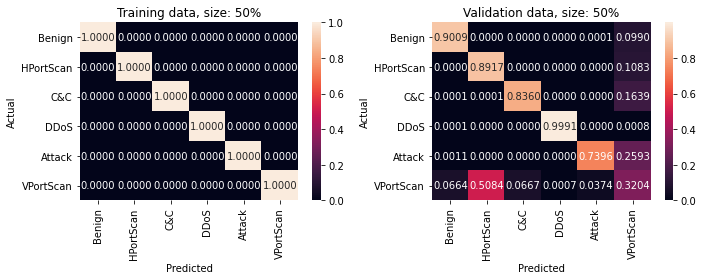

,val_size,f1_tr_mean,f1_tr_std,f1_val_mean,f1_val_std
0,20,1.0,0.0,0.848352,0.003718
1,30,1.0,0.0,0.838628,0.004432
2,40,1.0,0.0,0.825529,0.003224
3,50,1.0,0.0,0.815850,0.003547


In [30]:
# Show results
gs_results_test_6_2_avg = testing.average_results(gs_results_test_6_2, vertical_scans=True)

> With the 2nd correction for the IP response address 192.168.2.5 and response port 22, the classifier performs much worse across the different splittings. 

---
### **Summary**
---

In [31]:
def plot_summary_results(zoom=False):
    # Plot all results from validation together
    dataframes = [gs_results_test_1_avg,
                  gs_results_test_2_1_avg,
                  gs_results_test_2_2_avg,
                  gs_results_test_3_avg,
                  gs_results_test_4_avg,
                  gs_results_test_5_1_avg,
                  gs_results_test_5_2_avg,
                  gs_results_test_5_3_avg,
                  gs_results_test_6_1_avg,
                  gs_results_test_6_2_avg
                 ]

    labels = ['IPv4 to octets, rest categorical to dummies',
              'IPv4 to octets, rest categorical enumerated',
              'IPv4 to octets, history enumerated, rest categorical to dummies',
              'IPv4 to integers, rest categorical to dummies',
              'IPv4 to octets, rest categorical to dummies, add binary features',     
              'IPv4 to octets, rest categorical to dummies, add log transformations',  
              'IPv4 to octets, rest categorical to dummies, add power transformations',
              'IPv4 to octets, rest categorical to dummies, add quantile transformations',
              'Disentangle horizontal and vertical scans (1st correction)',
              'Disentangle horizontal and vertical scans (2nd correction)'
             ]

    # Define color palette and color range
    cm = plt.get_cmap('tab20')
    colorrange = np.arange(0,20)/20

    # Defind index for colorrange
    i=0

    # Plots
    fig, ax = plt.subplots(figsize=(10, 5))
    for (df,label) in zip (dataframes, labels):

        df_copy = df.copy()

        plt.errorbar(df_copy['val_size'], 
                     df_copy['f1_val_mean'], 
                     yerr=df_copy['f1_val_std'], 
                     label='VAL:'+label, marker='o', color=cm(colorrange[i]), ls='none')

        i=i+1


    plt.title('Comparison of different tests', fontsize=15)
    plt.xlabel('validation size', fontsize=13)
    plt.ylabel('avg f1-weighted', fontsize=13)
    plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
    
    if zoom==True:
        plt.ylim(0.99,1.002)
    plt.show()

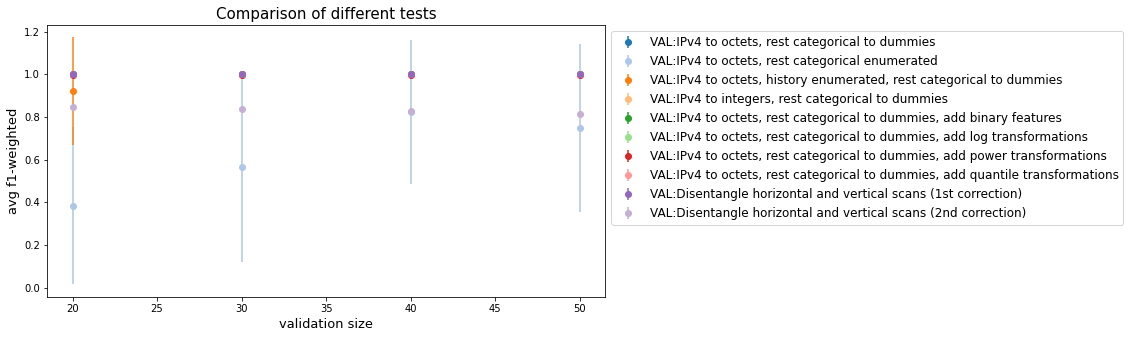

In [32]:
# General
plot_summary_results()

> As we see from the plot above by disentangling the horizontal from vertical scans we got the highest *f1-scores*

<div class="alert alert-block alert-success">
<b>Summary</b> 
<hr>

From the tests performed with the RandomForest classifier we saw that:
- the addition of the binary features or the transformed features did not really change the overall results
- the encoding of the IPv4 addresses as integers does not really have a difference with the octets representation, however this encoding slows down the preprocessing step as it is performed entry-by-entry
- for the encoding of the rest categorical features the best choice is to convert them all to dummies 
- by disentagling the horizontal from the vertical scans only with the 1st correction, the misclassification of malware entries being classified as benign was a bit decreased while benign entries misclassified as malware was a bit increased. So, this correction is helpful if one wants to catch up all the malware that runs on a network traffic and does not bother to have benign entries misclassified as malware and needs to check them.     
    
So the final decision for the preprocessing step is as following:    
- enconding the categorical features to dummies
- enconding the IP addresses as octets 
    
while the target values will be corrected by disentagling the horizontal from the vertical scans only with the 1st correction. The latter will be perfomed below and a new csv file will be created and used in the next notebooks. 
    
</div>

---
#### **Correct labels and save results in a new csv file**
---

In [33]:
# Read the reduced data file
data_df = pd.read_csv(os.path.join('data', 'ioT_data_reduced.csv'))

# Apply correction to the labels
data_df = preprocess_step(data_df, first_correction=True, second_correction=False)

# Save to file
data_df.to_csv(os.path.join('data', 'ioT_data_reduced_labels_corrected.csv'), index=False)  